# Read in Libraries

In [1]:
import pandas as pd
from pathlib import Path
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import gaussian_kde
from collections import OrderedDict
from matplotlib.lines import Line2D
from scipy.stats import linregress
import os

# Set up environment

In [2]:
cruise = "EN617"
station_name = None 

In [3]:
data_root  = Path(rf"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data")
output_data = rf"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\IFCB\{cruise}"
#output_fig = rf"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report2\Outputs\{cruise}"
os.makedirs(output_data, exist_ok=True)

In [4]:
station_order = ["MVCO", "L1", "L2", "L3", "L4", "L5", "L6", "L7", "L8", "L9", "L10", "L11"]

# Get Season

In [5]:
cruise_meta = pd.read_csv(rf"{data_root}/processed_cruises_meta.csv")
cruise_season = cruise_meta.loc[cruise_meta['Cruise'] == cruise.lower(), 'month_name'].values[0]
cruise_season

'Jul'

# Read in IFCB Metadata

In [6]:
ifcb_meta = pd.read_csv(data_root / "IFCB" / cruise / f"{cruise.lower()}_ifcb_metadata.csv")

if station_name:
    ifcb_station_meta = ifcb_meta[ifcb_meta["station"] == station_name].copy()
else:
    ifcb_station_meta = ifcb_meta.copy()

#ifcb_station_meta = station_meta.copy()
ifcb_station_meta['file_source'] = 'IFCB'
ifcb_station_meta['filename'] = ifcb_station_meta["pid"] + "_fea_v4.csv"
ifcb_station_meta['multiname'] = ifcb_station_meta["pid"] + "_multiblob_v4.csv"
ifcb_station_meta.head()

,cruise,cast,date,latitude,longitude,nearest_station,distance_km,pid,ifcb,ml_analyzed,sample_type,niskin,depth,skip,fea_file,multi_file,file_source,filename,multiname
0,en617,1,2018-07-20 17:23:53+00:00,41.200667,-70.885333,L1,0.472,D20180720T184414_IFCB109,109.0,1.572351,cast,12,1.796,0.0,Y:\NESLTER_transect\features\D2018\D20180720\D...,NaN,IFCB,D20180720T184414_IFCB109_fea_v4.csv,D20180720T184414_IFCB109_multiblob_v4.csv
1,en617,1,2018-07-20 17:23:53+00:00,41.200667,-70.885333,L1,0.472,D20180720T190050_IFCB109,109.0,1.547778,cast,12,1.796,0.0,Y:\NESLTER_transect\features\D2018\D20180720\D...,NaN,IFCB,D20180720T190050_IFCB109_fea_v4.csv,D20180720T190050_IFCB109_multiblob_v4.csv
2,en617,1,2018-07-20 17:23:53+00:00,41.200667,-70.885333,L1,0.472,D20180720T191853_IFCB109,109.0,1.508746,cast,12,1.796,0.0,Y:\NESLTER_transect\features\D2018\D20180720\D...,NaN,IFCB,D20180720T191853_IFCB109_fea_v4.csv,D20180720T191853_IFCB109_multiblob_v4.csv
3,en617,1,2018-07-20 17:23:53+00:00,41.200667,-70.885333,L1,0.472,D20180720T193536_IFCB109,109.0,1.017873,cast,8,7.261,0.0,Y:\NESLTER_transect\features\D2018\D20180720\D...,NaN,IFCB,D20180720T193536_IFCB109_fea_v4.csv,D20180720T193536_IFCB109_multiblob_v4.csv
4,en617,1,2018-07-20 17:23:53+00:00,41.200667,-70.885333,L1,0.472,D20180720T195316_IFCB109,109.0,2.590303,cast,8,7.261,0.0,Y:\NESLTER_transect\features\D2018\D20180720\D...,NaN,IFCB,D20180720T195316_IFCB109_fea_v4.csv,D20180720T195316_IFCB109_multiblob_v4.csv


# Read IFCB traits

In [7]:
trait_frames = []

for _, row in ifcb_meta.iterrows():
    # --- Single blob features ---
    fea_path = Path(row["fea_file"])
    if fea_path.exists():
        try:
            df_fea = pd.read_csv(fea_path)
            df_fea = df_fea[
                (df_fea["numBlobs"] == 1)
                & (df_fea["Biovolume"] > 0)
                & (df_fea["SurfaceArea"] > 0)
                & (df_fea["maxFeretDiameter"] > 0)
                & (df_fea["minFeretDiameter"] > 0)
            ].copy()

            df_fea["GALD"] = df_fea["maxFeretDiameter"]
            df_fea["S_to_V"] = df_fea["SurfaceArea"] / df_fea["Biovolume"]
            df_fea["shape_complexity"] = df_fea["Perimeter"]**2 / (4 * np.pi * df_fea["Area"])
            df_fea["aspect_ratio"] = df_fea["maxFeretDiameter"] / df_fea["minFeretDiameter"]

            df_fea["pid"] = row["pid"]
            df_fea["station"] = row["nearest_station"]
            df_fea["ml_analyzed"] = row["ml_analyzed"]
            df_fea["latitude"] = row["latitude"]
            df_fea["file_source"] = "IFCB_single"
            df_fea["cruise"] = row["cruise"]
            df_fea["cast"] = row["cast"]
            df_fea["niskin"] = row["niskin"]

            trait_frames.append(df_fea)
        except Exception as e:
            print(f"Could not read {fea_path}: {e}")

    # --- Multi-blob features (if available) ---
    if "multi_file" in row and isinstance(row["multi_file"], str):
        multi_path = Path(row["multi_file"])
        if multi_path.exists():
            try:
                df_multi = pd.read_csv(multi_path)
                df_multi = df_multi[
                    (df_multi["Biovolume"] > 0)
                    & (df_multi["SurfaceArea"] > 0)
                    & (df_multi["maxFeretDiameter"] > 0)
                    & (df_multi["minFeretDiameter"] > 0)
                ].copy()

                df_multi["GALD"] = df_multi["maxFeretDiameter"]
                df_multi["S_to_V"] = df_multi["SurfaceArea"] / df_multi["Biovolume"]
                df_multi["shape_complexity"] = df_multi["Perimeter"]**2 / (4 * np.pi * df_multi["Area"])
                df_multi["aspect_ratio"] = df_multi["maxFeretDiameter"] / df_multi["minFeretDiameter"]

                df_multi["pid"] = row["pid"]
                df_multi["station"] = row["nearest_station"]
                df_multi["ml_analyzed"] = row["ml_analyzed"]
                df_multi["latitude"] = row["latitude"]
                df_multi["file_source"] = "IFCB_multi"
                df_multi["cruise"] = row["cruise"]
                df_multi["cast"] = row["cast"]
                df_multi["niskin"] = row["niskin"]

                # Align with single-blob schema
                if "blob_number" in df_multi.columns:
                    df_multi = df_multi.rename(columns={"blob_number": "numBlobs"})

                trait_frames.append(df_multi)

            except Exception as e:
                print(f"Could not read {multi_path}: {e}")

# --- Combine both ---
if trait_frames:
    ifcb_traits = pd.concat(trait_frames, ignore_index=True)
    print(f"Combined dataframe shape: {ifcb_traits.shape}")
else:
    ifcb_traits = pd.DataFrame()
    print("No valid IFCB feature files found.")


Combined dataframe shape: (293073, 43)


In [8]:
#ifcb_traits = pd.concat(trait_frames, ignore_index=True)
print(ifcb_traits[["GALD", "S_to_V", "shape_complexity", "station", 'numBlobs']].describe())

                GALD         S_to_V  shape_complexity  numBlobs
count  293073.000000  293073.000000     293073.000000  293073.0
mean       29.256788       0.466027          1.463374       1.0
std        46.699647       0.252036          0.996874       0.0
min         8.944014       0.026906          0.591132       1.0
25%        19.235353       0.333201          1.166593       1.0
50%        23.409399       0.427780          1.264198       1.0
75%        30.016661       0.539453          1.449889       1.0
max      1454.030563       3.851027         70.091610       1.0


In [9]:
rows, columns = ifcb_traits.shape
print(f"Number of rows: {rows}, Number of columns: {columns}")

Number of rows: 293073, Number of columns: 43


# Exclude ROIs of Detritus, Metazoan, and IFCB artifacts

In [10]:
exclude_path = Path(rf"{data_root}\IFCB\{cruise}\{cruise.lower()}_rois_to_exclude.csv")
exclude_df = pd.read_csv(exclude_path)
exclude_df = exclude_df.rename(columns={"sampleID": "pid"})
exclude_df.head()

,pid,roi_number
0,D20180720T184414_IFCB109,11
1,D20180720T184414_IFCB109,17
2,D20180720T184414_IFCB109,44
3,D20180720T184414_IFCB109,60
4,D20180720T184414_IFCB109,68


In [11]:
# Merge with exclusion list to identify rows to drop
merged = ifcb_traits.merge(
    exclude_df, on=["pid", "roi_number"], how="left", indicator=True
)

# Keep only rows not in exclusion list
ifcb_clean = merged[merged["_merge"] == "left_only"].drop(columns=["_merge"])

In [12]:
ifcb_clean.columns

Index(['roi_number', 'Area', 'Biovolume', 'BoundingBox_xwidth',
       'BoundingBox_ywidth', 'ConvexArea', 'ConvexPerimeter', 'Eccentricity',
       'EquivDiameter', 'Extent', 'MajorAxisLength', 'MinorAxisLength',
       'Orientation', 'Perimeter', 'RepresentativeWidth', 'Solidity',
       'SurfaceArea', 'maxFeretDiameter', 'minFeretDiameter', 'numBlobs',
       'summedArea', 'summedBiovolume', 'summedConvexArea',
       'summedConvexPerimeter', 'summedMajorAxisLength',
       'summedMinorAxisLength', 'summedPerimeter', 'summedSurfaceArea',
       'Area_over_PerimeterSquared', 'Area_over_Perimeter',
       'summedConvexPerimeter_over_Perimeter', 'GALD', 'S_to_V',
       'shape_complexity', 'aspect_ratio', 'pid', 'station', 'ml_analyzed',
       'latitude', 'file_source', 'cruise', 'cast', 'niskin'],
      dtype='object')

In [13]:
rows, columns = ifcb_clean.shape
print(f"Number of rows: {rows}, Number of columns: {columns}")

Number of rows: 243088, Number of columns: 43


# Export cleaned IFCB Data

In [14]:
out_file = os.path.join(output_data, rf"{cruise}_ifcb_clean.csv")
ifcb_clean.to_csv(out_file, index=False)
print(f"Exported IFCB data to: {out_file}")

Exported IFCB data to: C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\IFCB\EN617\EN617_ifcb_clean.csv


# IFCB Slopes

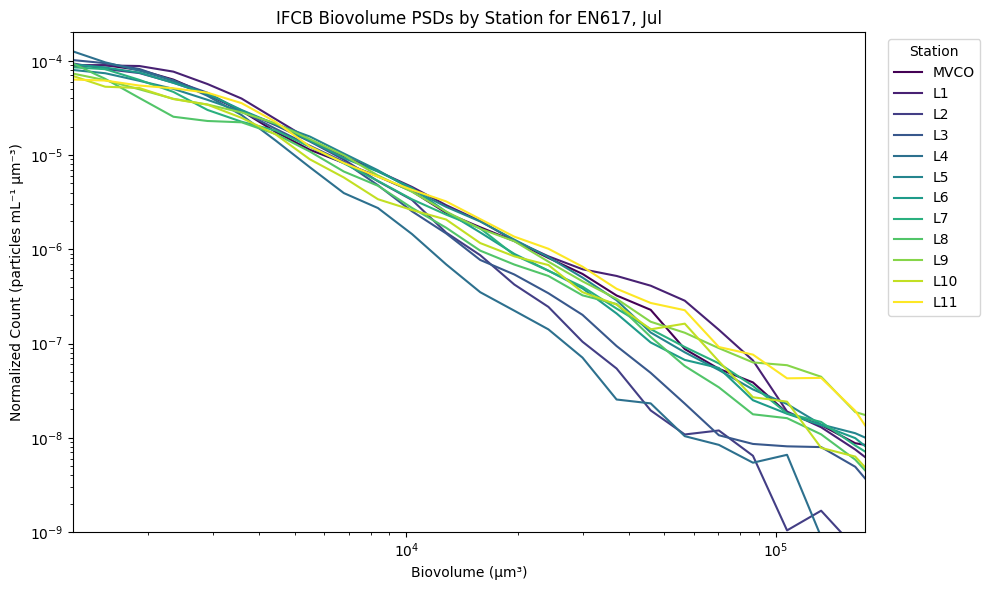

In [15]:
# Log bins for Biovolume
bins = np.logspace(np.log10(30), np.log10(1e6), 50)
bin_centers = np.sqrt(bins[:-1] * bins[1:])
bin_widths = np.diff(bins)

# Ordered stations (categorical but sortead)
station_order = ["MVCO", "L1", "L2", "L3", "L4", "L5", "L6", "L7", "L8", "L9", "L10", "L11"]
N = len(station_order)

# Gradient colormap
cmap = cm.viridis
colors = [cmap(i / (N - 1)) for i in range(N)]  # evenly spaced

station_colors = dict(zip(station_order, colors))

# 4. Plot
plt.figure(figsize=(10, 6))

for i, station in enumerate(station_order):
    df = ifcb_traits[ifcb_traits["station"] == station].dropna(subset=["Biovolume", "ml_analyzed"])
    if df.empty:
        continue

    counts, _ = np.histogram(df["Biovolume"], bins=bins)
    ml_sum = df["ml_analyzed"].sum()
    density = counts / (ml_sum * bin_widths)

    plt.plot(bin_centers, density, label=station, color=station_colors[station])

# Axes formatting
plt.xscale("log")
plt.yscale("log")
plt.xlim(1250, 175000)  # µm³
plt.ylim(1e-9, 0.0002)

plt.xlabel("Biovolume (µm³)")
plt.ylabel("Normalized Count (particles mL⁻¹ µm⁻³)")
plt.title(rf"IFCB Biovolume PSDs by Station for {cruise}, {cruise_season}")

# Custom legend
handles = [Line2D([0], [0], color=station_colors[st], label=st) for st in station_order]
plt.legend(handles=handles, title="Station", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
#plt.savefig(output_fig + "/ifcbPSD.png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
slopes = []

xmin, xmax = 1250, 175000

for station in station_order:
    df = ifcb_traits[ifcb_traits["station"] == station].dropna(subset=["Biovolume", "ml_analyzed"])
    if df.empty:
        continue

    counts, _ = np.histogram(df["Biovolume"], bins=bins)
    ml_sum = df["ml_analyzed"].sum()
    density = counts / (ml_sum * bin_widths)

    mask = (bin_centers >= xmin) & (bin_centers <= xmax)
    x = bin_centers[mask]
    y = density[mask]

    # Only use non-zero values
    x = x[y > 0]
    y = y[y > 0]

    if len(x) < 2:
        slope = np.nan
    else:
        #slope, _, _, _, _ = linregress(np.log10(x), np.log10(y))
        slope, intercept, r_value, p_value, std_err = linregress(np.log10(x), np.log10(y))

    #slopes.append({"station": station, "slope": slope})
    slopes.append({
        "station": station,
        "slope": abs(slope),
        "stderr": std_err
    })

# Convert to table
slope_df = pd.DataFrame(slopes)


In [17]:
slope_df

,station,slope,stderr
0,MVCO,2.033236,0.040365
1,L1,1.986189,0.062688
2,L2,2.678101,0.080585
3,L3,2.350778,0.053384
4,L4,2.606368,0.054033
5,L5,2.019464,0.048376
6,L6,2.093477,0.039227
7,L7,2.003422,0.032931
8,L8,2.023174,0.048745
9,L9,1.801460,0.036562


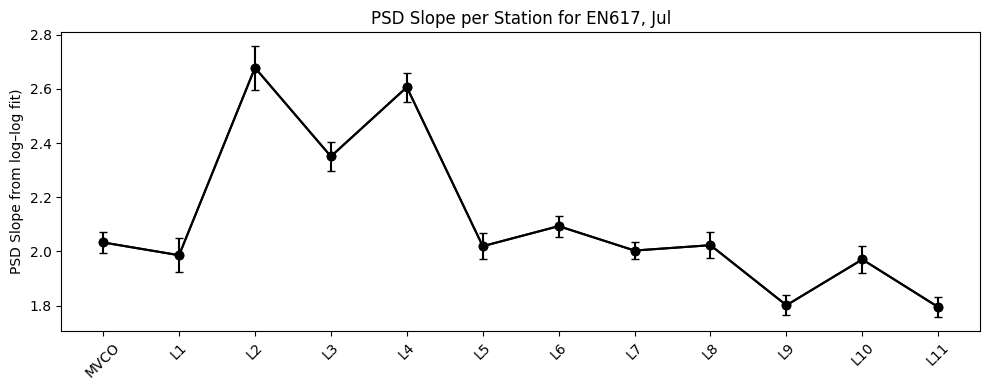

In [18]:
# Make sure slope_df is sorted by station_order
slope_df["station"] = pd.Categorical(slope_df["station"], categories=station_order, ordered=True)
slope_df = slope_df.sort_values("station")

plt.figure(figsize=(10, 4))
plt.plot(slope_df["station"], slope_df["slope"], marker="o", linestyle="-", color="black")
plt.errorbar(
    slope_df["station"], slope_df["slope"],
    yerr=slope_df["stderr"],
    fmt="o-", color="black", capsize=3
)


plt.xlabel("")
plt.ylabel("PSD Slope from log–log fit)")
plt.title(rf"PSD Slope per Station for {cruise}, {cruise_season}")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.savefig(output_fig + "/slopePSD.png", dpi=300, bbox_inches="tight")
plt.show()


In [19]:
out_slope = os.path.join(output_data, rf"{cruise}_ifcb_psd_slope.csv")
slope_df.to_csv(out_slope, index=False)
print(f"Exported PSD slope data to: {out_slope}")

Exported PSD slope data to: C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\IFCB\EN617\EN617_ifcb_psd_slope.csv
